# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
# common import for all cells
SEED=202
DATA_DIR=r'/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/submission(notebook+html)/002/data'
OUT_DIR =r'/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/submission(notebook+html)/002/out'

# standard libs
import pickle
import csv
from timeit import default_timer as timer
import os
import sys


#visualisation
%matplotlib inline

import matplotlib.pyplot as plt 
from IPython.display import Image
from IPython.display import display

# numerical libs 
import cv2
import math

import random
import numpy as np
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
tf.set_random_seed(SEED)

from tensorflow.python.training import moving_averages
from tensorflow.contrib.framework import add_model_variable
sess = tf.InteractiveSession()



---
## Step 0: Load The Data

In [2]:
# Load pickled data  
# TODO: Fill this in based on where you saved the training and testing data

def load_data(): 
    training_file  = DATA_DIR + '/train.p'
    testing_file   = DATA_DIR + '/test.p'
    classname_file = DATA_DIR + '/signnames.csv'

    classnames = []
    with open(classname_file) as _f:
        rows = csv.reader(_f, delimiter=',')
        next(rows, None)  # skip the headers
        for i, row in enumerate(rows):
            assert(i==int(row[0]))
            classnames.append(row[1])
 
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test   = test['features'], test['labels']
    
    
    X_train  = X_train.astype(np.float32)
    y_train  = y_train.astype(np.int32)
    X_test   = X_test.astype(np.float32)
    y_test   = y_test.astype(np.int32)
    
    return  classnames, X_train, y_train, X_test, y_test 


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

classnames, X_train, y_train, X_test, y_test = load_data() 
 
# TODO: Number of training examples 
num_train = len(X_train)

# TODO: Number of testing examples.
num_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
_, height, width, channel = X_train.shape
image_shape = (height, width, channel)

# TODO: How many unique classes/labels there are in the dataset.
num_class = len(np.unique(y_train))


print("Number of training examples =", num_train )
print("Number of testing examples =", num_test )
print("Image data shape =", image_shape)
print("Number of classes =", num_class)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.


#help function to draw graph,etc  
def get_label_image(c): 
    img=cv2.imread(DATA_DIR+'/signnames_all.jpg',1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    H, W, _ = img.shape
    dH = H/7.
    dW = W/7.105
    y = c//7
    x = c%7 
    label_image = img[round(y*dH):round(y*dH+dH), round(x*dW):round(x*dW+dW),:]
    label_image = cv2.resize(label_image, (0,0), fx=32./dW, fy=32./dH,)
    return label_image


def insert_subimage(image, sub_image, y, x): 
    h, w, c = sub_image.shape
    image[y:y+h, x:x+w, :]=sub_image 
    return image

** training data summary **
	1st column: label(image)
	2nd column: mean image
	other column: example images
	black text: label
	blue text: sanple count for each class and histogram plot


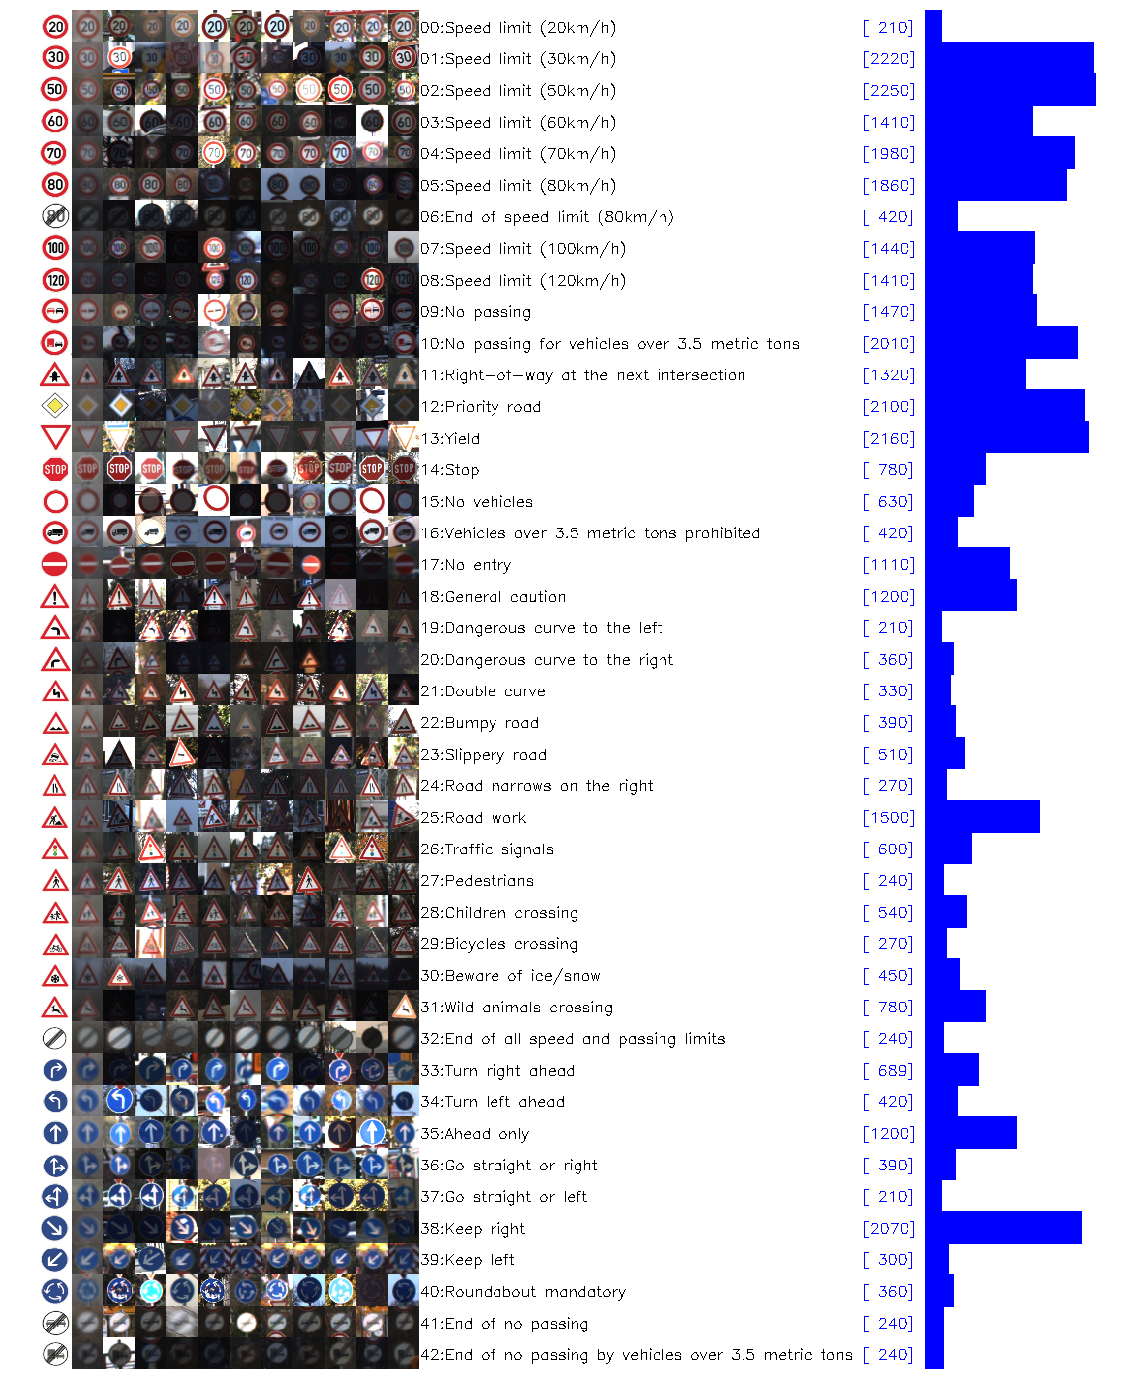

In [64]:
images, labels = X_train, y_train
#images, labels = X_test, y_test
    
#count
#h = np.histogram(train_labels, bins=np.arange(num_class))

#results image
num_sample=10
results_image = 255.*np.ones(shape=(num_class*height,(num_sample+2+22)*width, channel),dtype=np.float32)
for c in range(num_class):
    label_image = get_label_image(c)
    insert_subimage(results_image, label_image, c*height, 0)

    #make mean
    idx = list(np.where(labels== c)[0])
    mean_image = np.average(images[idx], axis=0)
    insert_subimage(results_image, mean_image, c*height, width)

    # imshow('mean_image',mean_image)
    # imshow('label_image',label_image)
    # cv2.waitKey(0)

    #make random sample
    for n in range(num_sample):
        sample_image = images[np.random.choice(idx)]
        insert_subimage(results_image, sample_image, c*height, (2+n)*width)

    #print summary
    count=len(idx)
    percentage = float(count)/float(len(images))
    cv2.putText(results_image, '%02d:%-6s'%(c, classnames[c]), ((2+num_sample)*width, int((c+0.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,0),1)
    cv2.putText(results_image, '[%4d]'%(count), ((2+num_sample+14)*width, int((c+0.7)*height)),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1)
    cv2.rectangle(results_image,((2+num_sample+16)*width, c*height),((2+num_sample+16)*width + round(percentage*3000), (c+1)*height),(0,0,255),-1)

 
cv2.imwrite(OUT_DIR+'/train_data_summary.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
#cv2.imwrite(OUT_DIR+'/test_data_summary.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
#imshow('results_image',results_image)
#cv2.waitKey(0)


print('** training data summary **')
print('\t1st column: label(image)')
print('\t2nd column: mean image')
print('\tother column: example images')
print('\tblack text: label')
print('\tblue text: sanple count for each class and histogram plot')
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

 

** comments **

It is noted that the mean image of each class is rather well define. Hence we do not expect the classification to be too difficult.The data varies greatly in illumintion. There is some affine transformation and blur. Lastly, the histogram of the samples shows that the class is not balanced.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [6]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# our preprocessing is built inside the network:
# with tf.variable_scope('preprocess') as scope:
#     input = bn(input, name='b1')
#     input = conv2d(input, num_kernels=8, kernel_size=(3, 3), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c1')
#     input = prelu(input, name='r1')
#     input = conv2d(input, num_kernels=8, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c2')
#     input = prelu(input, name='r2')


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Note: you can refer to my github or blog for more details:)
- https://github.com/hengck23-udacity/udacity-driverless-car-nd-p2
- https://medium.com/@hengcherkeng/updated-my-99-40-solution-to-udacity-nanodegree-project-p2-traffic-sign-classification-5580ae5bd51f#.28l99uq77


We did not use any data preprocessing methods (e.g. color conversion, whitening, histograms). Instead, we use the first few layer layers of our network for preprocessing. This is inspired by [1]. Like the "spatial transformer", we want to design a "illumination transformer" to auto correct the image color, contrast, etc. We use small convolution kernels of 3x3 and 1x1 and learnable parametric ReLU.


[1]"Systematic evaluation of CNN advances on the ImageNet"-Dmytro Mishkin, Nikolay Sergievskiy, Jiri Matas, ARXIV 2016 (https://arxiv.org/abs/1606.02228)

In [7]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


# split into train and validation. 
def split_data(X_train, y_train, num_valid=3000): 
    # num_valid = num of validation samples
     
    num   = len(y_train)   # 39209 
    index = list(range(num))
    random.shuffle(index)
    train_index=index[num_valid:]
    valid_index=index[:num_valid]


    train_images = X_train[train_index] 
    train_labels = y_train[train_index]
    valid_images = X_train[valid_index] 
    valid_labels = y_train[valid_index] 
   
    return  train_images, train_labels,  valid_images, valid_labels

 

In [8]:
#this expand the train data by flipping.
#  Note: this code is from : http://navoshta.com/traffic-signs-classification/ !!!!!!!!!!!!!!
#  This is the only code *not* from me.
def extend_data_by_flipping(images, labels):

    X=images
    y=labels

    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38],
    ])
    num_classes = 43

    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype=np.float32)
    y_extended = np.empty([0], dtype=np.int32)

    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis=0)
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis=0)
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis=0)
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c, dtype=np.int32))

    extend_datas  = X_extended
    extend_labels = y_extended
    return (extend_datas, extend_labels)


In [9]:
# use opencv to do data agumentation
# see also: https://github.com/dmlc/mxnet/blob/master/python/mxnet/image.py
def perturb(image, keep, angle_limit=15, scale_limit=0.1, translate_limit=3, distort_limit=3, illumin_limit=0.7):

    u=np.random.uniform()
    if u>keep :
        #geometric -------------
        (W, H, C) = image.shape
        center = np.array([W / 2., H / 2.])
        da = np.random.uniform(low=-1, high=1) * angle_limit/180. * math.pi
        scale = np.random.uniform(low=-1, high=1) * scale_limit + 1

        cc = scale*math.cos(da)
        ss = scale*math.sin(da)
        rotation    = np.array([[cc, ss],[-ss,cc]])
        translation = np.random.uniform(low=-1, high=1, size=(1,2)) * translate_limit
        distort     = np.random.standard_normal(size=(4,2)) * distort_limit

        pts1 = np.array([[0., 0.], [0., H], [W, H], [W, 0.]])
        pts2 = np.matmul(pts1-center, rotation) + center  + translation

        #add perspective noise
        pts2 = pts2 + distort


        #http://milindapro.blogspot.jp/2015/05/opencv-filters-copymakeborder.html
        matrix  = cv2.getPerspectiveTransform(pts1.astype(np.float32), pts2.astype(np.float32)) 
        perturb = cv2.warpPerspective(image, matrix, (W, H), flags=cv2.INTER_LINEAR,
                                      borderMode=cv2.BORDER_REFLECT_101)  # BORDER_WRAP  #BORDER_REFLECT_101  #cv2.BORDER_CONSTANT  BORDER_REPLICATE

        #illumination -------------
        #from mxnet code
        
        #brightness
        alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
        perturb *= alpha
        perturb = np.clip(perturb,0.,255.)
        pass

        #contrast
        coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

        alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
        gray = perturb * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        perturb *= alpha
        perturb += gray
        perturb = np.clip(perturb,0.,255.)
        pass

        #saturation
        coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B

        alpha = 1.0 + illumin_limit*random.uniform(-1, 1)
        gray = perturb * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        gray *= (1.0 - alpha)
        perturb *= alpha
        perturb += gray
        perturb = np.clip(perturb,0.,255.)
        pass

        return perturb

    else:
        return image
    
    
def make_perturb_images(images, keep ):
    arguments = np.zeros(images.shape)
    for n in range(len(images)):
        arguments[n] = perturb(images[n],keep = keep)

    return arguments


# sample and shuffle the data such that each class has equal number of samples for training
def shuffle_data_uniform(datas, labels, num_class, num_per_class=None):

    if num_per_class is None:
        max_count = 0
        for c in range(num_class):
            idx = list(np.where(labels == c)[0])
            count = len(idx)
            max_count = max(count, max_count)
        num_per_class = max_count

    index = []
    for c in range(num_class):
        idx = list(np.where(labels == c)[0])
        index = index + list(np.random.choice(idx, num_per_class))

    random.shuffle(index)
    shuffle_datas  = datas[index]
    shuffle_labels = labels[index]

    return shuffle_datas, shuffle_labels

#generate next batch for sdg
def generate_train_batch_next(datas, labels, n, batch_size):
    i = n*batch_size
    batch_datas  = datas [i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    return batch_datas, batch_labels


** some data setting **
	height, width, channel = 32, 32, 3
	num_test  = 12630
	num_valid = 3000
	num_train = 36209

	num_train (after flip)= 62187
	num_argument = 860000


examples of argument images (first column is orginal)


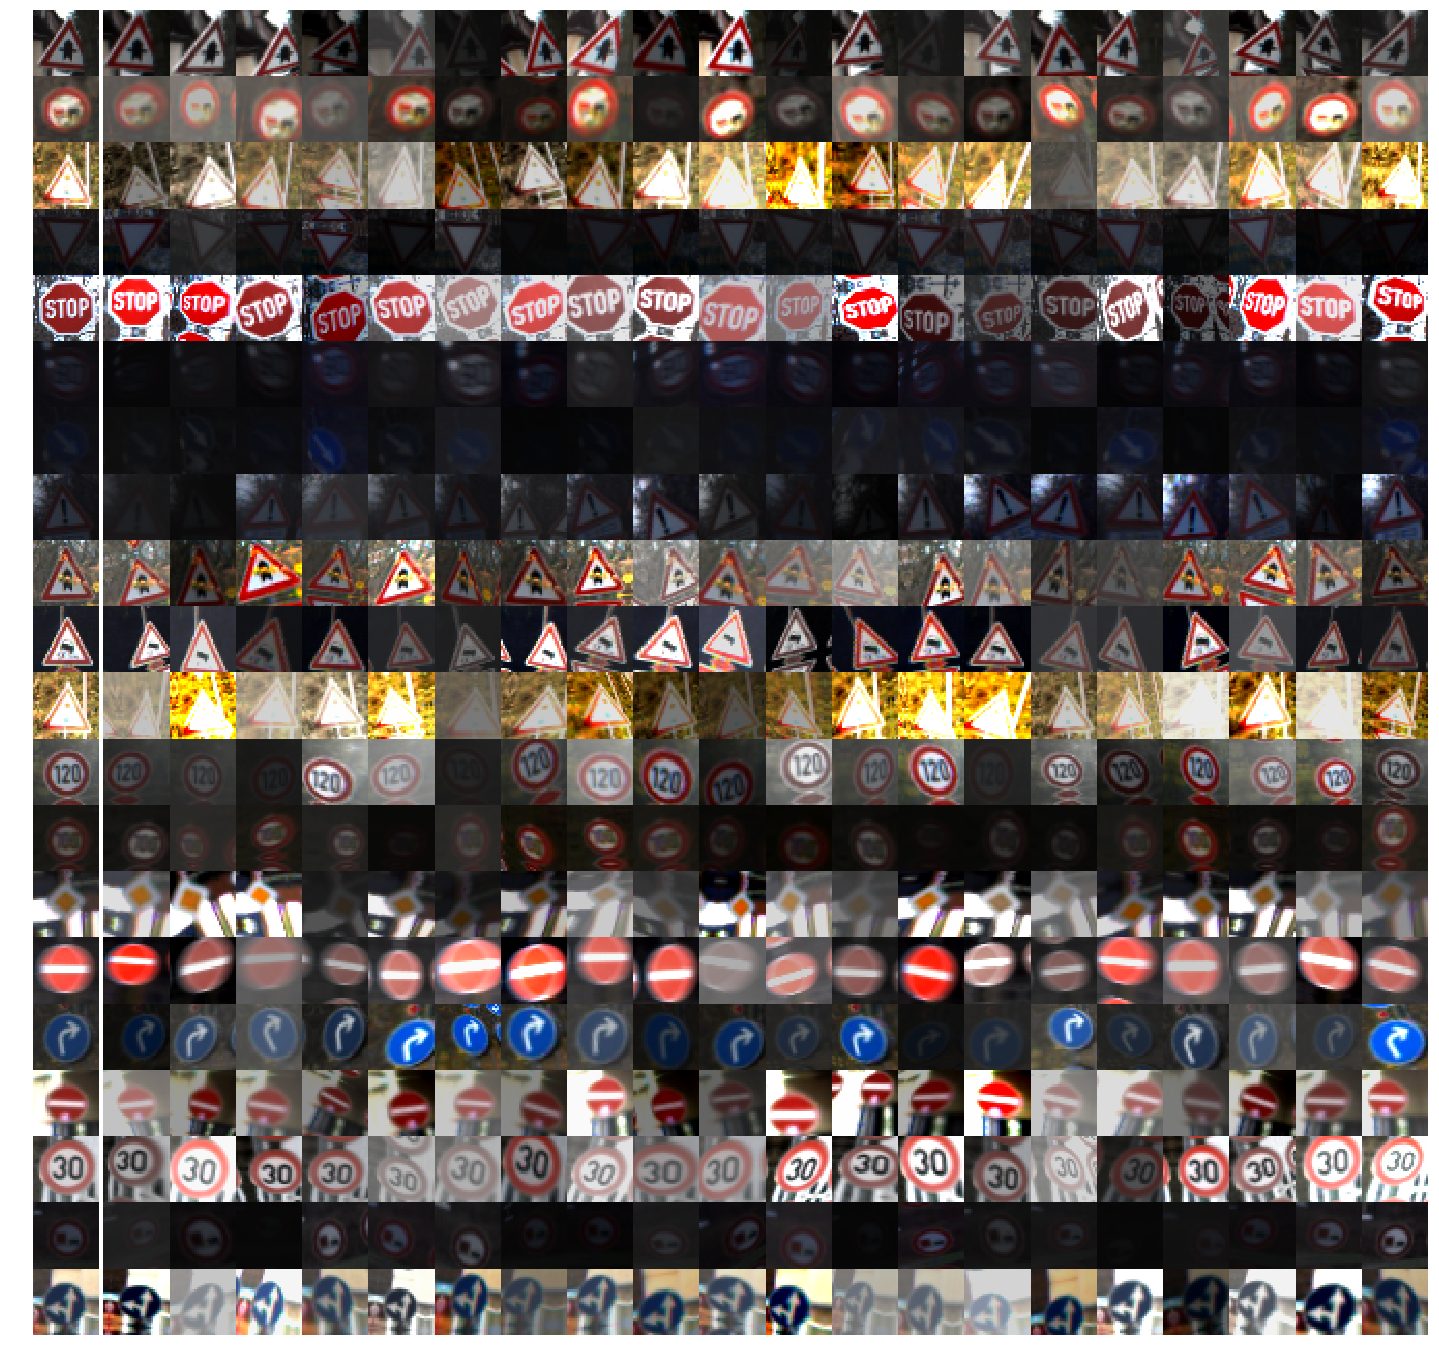

In [65]:
#prepare all data here 
classnames, X_train, y_train, X_test, y_test = load_data() 

train_images, train_labels,  valid_images, valid_labels = split_data(X_train, y_train)
test_images, test_labels = X_test, y_test
 
num_train = len(train_images)
num_valid = len(valid_images)
num_test  = len(test_images)
    
print('** some data setting **')
print('\theight, width, channel = %d, %d, %d'%(height, width, channel))
print('\tnum_test  = %d'%num_test)
print('\tnum_valid = %d'%num_valid)
print('\tnum_train = %d'%num_train)

#train data filpping.
train_images, train_labels = extend_data_by_flipping(train_images, train_labels) 
num_train_flip = len(train_images)
print('')
print('\tnum_train (after flip)= %d' % num_train_flip )
 
#train data augmentation 
keep = 0.20   # 0.50   0.25 0.20   #0.15
num_per_class = 20000
num_argument = num_per_class*num_class
#argument_images, argument_labels = shuffle_data_uniform(train_images, train_labels, num_class, num_per_class=num_per_class)
#argument_images = make_perturb_images(argument_images, keep=keep) 
#num_argument = len(argument_images) 
print('\tnum_argument = %d' % num_argument)  
 
    
    
#example of new generated train data -------------------------------------------- 
print('\n')
print('examples of argument images (first column is orginal)')
 

# results image
num_sample = 20
perturbance_per_sample = 20

results_image = 255. * np.ones(shape=(num_sample * height, (perturbance_per_sample+1)* width+2, channel),dtype=np.float32)

for j in range(num_sample):
    i = random.randint(0, num_train_flip - 1)

    image = train_images[i]
    insert_subimage(results_image, image, j * height, 0)

    for k in range(0, perturbance_per_sample):
        perturb_image = perturb(image, keep=0)
        insert_subimage(results_image, perturb_image, j*height, (k+1)*width+2)

         
cv2.imwrite(OUT_DIR+'/data_perturb.jpg',cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()
    

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**
We set aside 3000 train samples for validation and the rest 36209 for training. For 12630 test data, we leave all of it untouched. In order to create more data, we use the methods

- We first flip the train sample to extend the training set to 62259. This is inspired by the work of http://navoshta.com/traffic-signs-classification/

- Next, to keep the class balance, we first re-sample the training set so that we have 20000 samples per class. This gives 43x2000=860000 train samples.

- Finally, we randomly select 80% train samples to add random geometric transform and illumination transform. Geometric transform include rotate, scale, transalate and perspective distortion noise. Illumination transform includes brightness, contast and saturation. These transforms are selected to mimick the data variations we found in the training images, which we have shown above.


We note that from our experiments, the illumination transform gives good improvemet in the test accuracy. The new augmented data is more class balance and has more variations then the original data.


In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

# we define the basic ops first -----------------------------------------

##  global varaiables ##
IS_TRAIN_PHASE = tf.placeholder(dtype=tf.bool, name='is_train_phase')

def conv2d(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='conv'):

    input_shape = input.get_shape().as_list()
    assert len(input_shape)==4
    C = input_shape[3]
    H = kernel_size[0]
    W = kernel_size[1]
    K = num_kernels

    ##[filter_height, filter_width, in_channels, out_channels]
    w    = tf.get_variable(name=name+'_weight', shape=[H, W, C, K], initializer=tf.truncated_normal_initializer(stddev=0.1))
    conv = tf.nn.conv2d(input, w, strides=stride, padding=padding, name=name)
    if has_bias:
        b = tf.get_variable(name=name + '_bias', shape=[K], initializer=tf.constant_initializer(0.0))
        conv = conv+b

    return conv


def relu(input, name='relu'):
    act = tf.nn.relu(input, name=name)
    return act

def prelu(input, name='prelu'):
  alpha = tf.get_variable(name=name+'_alpha', shape=input.get_shape()[-1],
                       #initializer=tf.constant_initializer(0.25),
                        initializer=tf.random_uniform_initializer(minval=0.1, maxval=0.3),
                        dtype=tf.float32)
  pos = tf.nn.relu(input)
  neg = alpha * (input - abs(input)) * 0.5

  return pos + neg


# very leaky relu
def vlrelu(input, alpha=0.25, name='vlrelu'): #  alpha between 0.1 to 0.5
    act =tf.maximum(alpha*input,input)
    return act

def maxpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, name='max' ):
    H = kernel_size[0]
    W = kernel_size[1]
    pool = tf.nn.max_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)
    return pool

def avgpool(input, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', has_bias=True, is_global_pool=False, name='avg'):

    if is_global_pool==True:
        input_shape = input.get_shape().as_list()
        assert len(input_shape) == 4
        H = input_shape[1]
        W = input_shape[2]

        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=[1,H,W,1], padding='VALID', name=name)
        pool = flatten(pool)

    else:
        H = kernel_size[0]
        W = kernel_size[1]
        pool = tf.nn.avg_pool(input, ksize=[1, H, W, 1], strides=stride, padding=padding, name=name)

    return pool


def dropout(input, keep=1.0, name='drop'):
    #drop = tf.cond(IS_TRAIN_PHASE, lambda: tf.nn.dropout(input, keep), lambda: input)
    drop = tf.cond(IS_TRAIN_PHASE,
                   lambda: tf.nn.dropout(input, keep),
                   lambda: tf.nn.dropout(input, 1))
    return drop


def flatten(input, name='flat'):
    input_shape = input.get_shape().as_list()        # list: [None, 9, 2]
    dim   = np.prod(input_shape[1:])                 # dim = prod(9,2) = 18
    flat  = tf.reshape(input, [-1, dim], name=name)  # -1 means "all"
    return flat

def concat(input, name='cat'):
    cat = tf.concat(concat_dim=3, values=input, name=name)
    return cat


#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard4/tf.contrib.layers.batch_norm.md
#http://www.bubufx.com/detail-1792794.html
def bn (input, decay=0.9, eps=1e-5, name='bn'):
    with tf.variable_scope(name) as scope:
        bn = tf.cond(IS_TRAIN_PHASE,
            lambda: tf.contrib.layers.batch_norm(input,  decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=1,reuse=None,
                              updates_collections=None, scope=scope),
            lambda: tf.contrib.layers.batch_norm(input, decay=decay, epsilon=eps, center=True, scale=True,
                              is_training=0, reuse=True,
                              updates_collections=None, scope=scope))

    return bn


In [6]:
# basic building blocks

def conv2d_bn_relu(input, num_kernels=1, kernel_size=(1,1), stride=[1,1,1,1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = conv2d(input, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
        block = bn(block)
        block = relu(block)
    return block


def bn_relu_conv2d (input, num_kernels=1, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', name='conv'):
    with tf.variable_scope(name) as scope:
        block = bn(input)
        block = relu(block)
        block = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=stride, padding=padding, has_bias=False)
    return block



# modified dense block from the paper [1] "Densely Connected Convolutional Networks" - Gao Huang, Zhuang Liu, Kilian Q. Weinberger, 
# Laurens van der Maaten, Arxiv 2016
# Modification: 
#   1. the paper uses bn-relu-conv but we use conv-bn-relu
#   2. the paper uses dropout inside the block but we shift the dropout outside the block see network construction later
def dense_block_cbr (input, num=1, num_kernels=1, kernel_size=(1, 1), drop=None, name='DENSE'):
 
    block = input
    for n in  range(num):
        with tf.variable_scope(name+'_%d'%n) as scope:
            conv = conv2d(block, num_kernels=num_kernels, kernel_size=kernel_size, stride=[1,1,1,1], padding='SAME', has_bias=False)
            conv = bn(conv)
            conv = relu(conv)

            if drop is not None:
                keep = (1 - drop) ** (1. / num)
                conv = dropout(conv, keep=keep)

            block = concat((block, conv))
    return block


In [7]:
# the loss 
def l2_regulariser(decay):

    variables = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    for v in variables:
        name = v.name
        if 'weight' in name:  #this is weight
            l2 = decay * tf.nn.l2_loss(v)
            tf.add_to_collection('losses', l2)
        elif 'bias' in name:  #this is bias
            pass
        elif 'beta' in name:
            pass
        elif 'gamma' in name:
            pass
        elif 'moving_mean' in name:
            pass
        elif 'moving_variance' in name:
            pass
        elif 'moments' in name:
            pass

        else:
            #pass
            #raise Exception('unknown variable type: %s ?'%name)
            pass

    l2_loss = tf.add_n(tf.get_collection('losses'))
    return l2_loss


def cross_entropy(logit, label, name='cross_entropy'):
    label = tf.cast(label, tf.int64)
    cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logit, label), name=name)
    return cross_entropy


def accuracy(prob, label, name='accuracy'):
    correct_prediction = tf.equal(tf.argmax(prob, 1), tf.cast(label, tf.int64))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name=name)
    return accuracy


In [8]:
# my densenet here!
#the inference part (without loss)

def DenseNet_3( input_shape=(1,1,1), output_shape = (1)):

    H, W, C   = input_shape
    num_class = output_shape
    input     = tf.placeholder(shape=[None, H, W, C], dtype=tf.float32, name='input')

    #color preprocessing using conv net:
    #see "Systematic evaluation of CNN advances on the ImageNet"-Dmytro Mishkin, Nikolay Sergievskiy, Jiri Matas, ARXIV 2016
    # https://arxiv.org/abs/1606.02228
    # we use learnable prelu (different from paper) and 3x3 onv
    with tf.variable_scope('preprocess') as scope:
        input = bn(input, name='b1')
        input = conv2d(input, num_kernels=8, kernel_size=(3, 3), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c1')
        input = prelu(input, name='r1')
        input = conv2d(input, num_kernels=8, kernel_size=(1, 1), stride=[1, 1, 1, 1], padding='SAME', has_bias=True, name='c2')
        input = prelu(input, name='r2')


    with tf.variable_scope('block1') as scope:
        block1 = conv2d_bn_relu(input, num_kernels=32, kernel_size=(5, 5), stride=[1, 1, 1, 1], padding='SAME')
        block1 = maxpool(block1, kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    # we use conv-bn-relu in DENSE block (different from paper)
    # dropout is taken out of the block
    with tf.variable_scope('block2') as scope:
        block2 = dense_block_cbr(block1, num=4, num_kernels=16, kernel_size=(3, 3), drop=None)
        block2 = maxpool(block2, kernel_size=(2, 2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block3') as scope:
        block3 = dense_block_cbr(block2, num=4, num_kernels=24, kernel_size=(3, 3), drop=None)
        block3 = dropout(block3, keep=0.9)
        block3 = maxpool(block3,  kernel_size=(2,2), stride=[1, 2, 2, 1], padding='SAME')

    with tf.variable_scope('block4') as scope:
        block4 = dense_block_cbr(block3, num=4, num_kernels=32, kernel_size=(3, 3), drop=None)
        block4 = conv2d_bn_relu(block4, num_kernels=num_class, kernel_size=(1,1), stride=[1, 1, 1, 1], padding='SAME')
        block4 = dropout(block4, keep=0.9)
        block4 = avgpool(block4, is_global_pool=True)


    logit = block4
    return logit


In [9]:
# construct the graph here
make_net = DenseNet_3  #LeNet_0  #LeNet_1

logit  = make_net(input_shape =(height, width, channel), output_shape=(num_class))
data   = tf.get_default_graph().get_tensor_by_name('input:0')
label  = tf.placeholder(dtype=tf.int32, shape=[None])
prob   = tf.nn.softmax(logit)

l2     = l2_regulariser(decay=0.0005)
loss   = cross_entropy(logit, label)
metric = accuracy(prob, label)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
Our network is shown in table below. It as about 27 million MACs (multiply-accumulation operation counts) and has test accuracy of abut 99.68%. The input is 32x32 3-channel input. Below table shows the network structure.

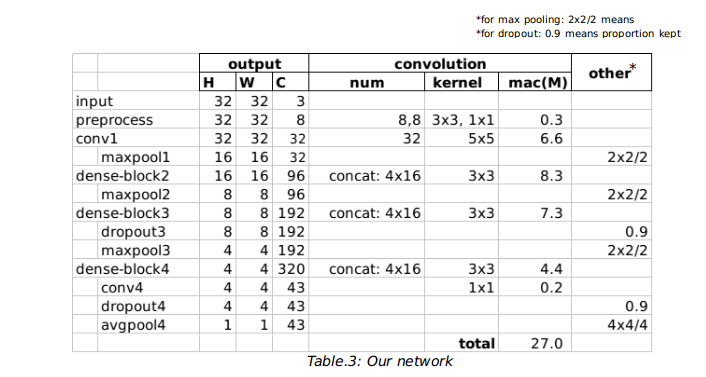

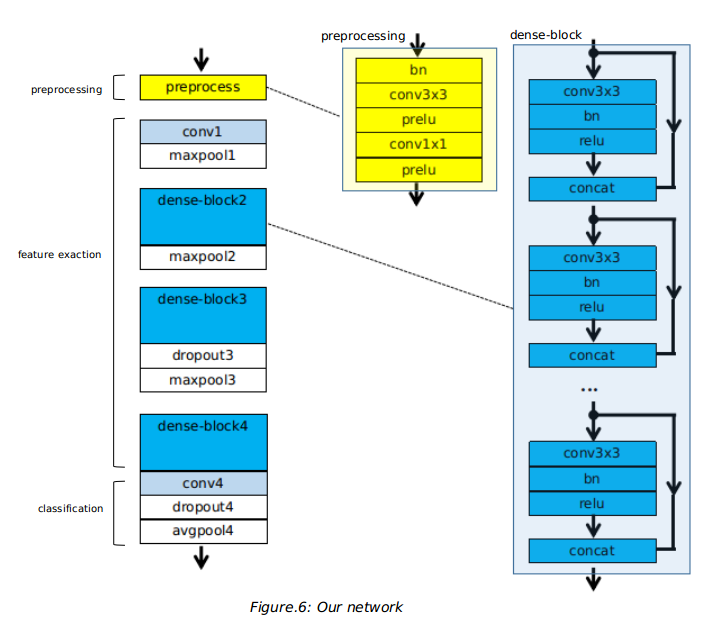

In [3]:
img1=Image(filename="/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/advance/docs/000.png")
img2=Image(filename="/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/advance/docs/001.png")
display(img1, img2)

Our network has the 3 following parts:

[Preprocessing]
- the input is first normalisalised by bn layer. Then it is "preprocessed" by 3x3 and 1x1 conv layers with learnable parameteric ReLU as activations. This is inspired by [1].

[Feature Extraction]
- the first block1(conv1) is simply 32 5x5 convolutions in "conv-bn-relu" format. Max pooling is used to reduce the size of the activation. 

- The next three block block2,3,4 are modified "Dense block", see [2]. Each "Dense block" consists of 4 concatenations of 3x3 convolutions in "conv-bn-relu" format. Note that unlike the paper, dropout is not applied in the block. Instead, we use droupout after the block for regularisation.


[Classification]

- Finally for classification, we apply 1x1 conv and global average pooling.
 
 
One uqiue feature of our network is the use of "Dense block" that allows input from lower layers to be "shortcut" to the upper layers. We think this is a way to use multi-scale features. For loss function, we use cross entropy for gradient descent. l2 weight regularisation is also applied.



[1]"Systematic evaluation of CNN advances on the ImageNet"-Dmytro Mishkin, Nikolay Sergievskiy, Jiri Matas, ARXIV 2016 (https://arxiv.org/abs/1606.02228)
[2] "Densely Connected Convolutional Networks" - Gao Huang, Zhuang Liu, Kilian Q. Weinberger, Laurens van der Maaten, Arxiv 2016

In [18]:
### Train your model here.
### Feel free to use as many code cells as needed.

# changing of learning rate
def schdule_by_step( r, steps=(0,100), items=(0.1,0.01)):

    item = items[0]
    N=len(steps)
    for n in range(N):
        if r >= steps[n]:
            item = items[n]
    return item


#for testing and validation
def test_net( datas, labels, batch_size, data, label, loss, metric, sess):

    num = len(datas)
    all_loss = 0
    all_acc = 0
    all = 0
    for n in range(0, num, batch_size):
        #print('\r  evaluating .... %d/%d' % (n, num), end='', flush=True)
        start = n
        end = start+batch_size if start+batch_size<=num else num
        batch_datas  = datas  [start:end]
        batch_labels = labels [start:end]

        fd = {data: batch_datas, label: batch_labels, IS_TRAIN_PHASE : False}
        test_loss, test_acc = sess.run([loss, metric], feed_dict=fd)

        a = end-start
        all += a
        all_loss += a*test_loss
        all_acc  += a*test_acc

    assert(all==num)
    loss = all_loss/all
    acc  = all_acc/all

    return loss, acc


In [19]:
#solver 
epoch_log  = 2 
max_run    = 9
batch_size = 128  #256  #96  384  #128
steps = (0, 3, 6, 8)  
rates = (0.1, 0.01,  0.001, 0.0001) 

learning_rate = tf.placeholder(tf.float32, shape=[])
solver = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9)
solver_step = solver.minimize(loss+l2)



# start training here ------------------------------------------------
print ('start training')
sess.run(tf.global_variables_initializer(), feed_dict = {IS_TRAIN_PHASE : True } )
saver  = tf.train.Saver()
#writer = tf.summary.FileWriter(out_dir + '/tf', graph=tf.get_default_graph())


# keep a log   
print('')
print(' run  epoch   iter    rate      |  train_loss    (acc)     |  valid_loss    (acc)     |  time ')
print('----------------------------------------------------------------------------------------------')

tic = timer()
iter = 0
for r in range(max_run):
    rate = schdule_by_step(r, steps=steps, items=rates)

    argument_images, argument_labels = shuffle_data_uniform(train_images, train_labels, num_class,  num_per_class=num_per_class)
    argument_images = make_perturb_images(argument_images, keep=keep)


    num_argument = len(argument_images)
    N = max(num_argument//batch_size-1,1)
    #iter_log = round(float(num_train) / float(num_argument) * float(N))
    iter_log = max(round(float( epoch_log *num_train ) / float(batch_size)),1)
    for n in range(N):
        iter  = iter + 1
        run   = r + float(n)/float(N)
        epoch = float(iter*batch_size)/float(num_train)

        batch_datas, batch_labels = generate_train_batch_next( argument_images, argument_labels, n, batch_size )

        fd = {data: batch_datas, label: batch_labels, learning_rate: rate, IS_TRAIN_PHASE : True }
        _, batch_loss, batch_acc, = sess.run([solver_step, loss, metric ],feed_dict=fd)

      
        print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f)  ' %
                  (run, epoch, iter, rate, batch_loss, batch_acc), end='', flush=True)

        #do validation here!
        if iter%iter_log==0 or (r==max_run-1 and n==N-1): 
            toc = timer()
            sec_pass = toc - tic
            min_pass = sec_pass/60.

            #validation
            val_loss, val_acc =  test_net(valid_images, valid_labels, batch_size, data, label, loss, metric, sess)

            #print('\r')
            print('\r%4.1f  %5.1f   %05d   %f |  %f    (%f) |  %f    (%f) | %4.1f min' %
                  (run, epoch, iter, rate, batch_loss, batch_acc, val_loss, val_acc, min_pass ), end='\n',flush=True)


        pass

    # save intermediate checkpoint
    # saver.save(sess, out_dir + '/check_points/%06d.ckpt'%r)  #iter


#final test! ------------------------------------------
# save final checkpoint
os.makedirs (OUT_DIR + '/check_points/final.ckpt',exist_ok=True)
saver.save(sess, OUT_DIR + '/check_points/final.ckpt')

print('\n') 
print('** evaluation on test set **' )
test_loss, test_acc = test_net(test_images, test_labels, batch_size, data, label, loss, metric, sess)
print('test_loss=%f    (test_acc=%f)' % ( test_loss, test_acc))

 


start training

 run  epoch   iter    rate      |  train_loss    (acc)     |  valid_loss    (acc)     |  time 
----------------------------------------------------------------------------------------------
 0.1    2.0   00566   0.100000 |  0.388836    (0.882812) |  0.252847    (0.919667) |  2.9 min
 0.2    4.0   01132   0.100000 |  0.196469    (0.929688) |  0.062733    (0.983333) |  3.3 min
 0.3    6.0   01698   0.100000 |  0.171962    (0.960938) |  0.134339    (0.960333) |  3.7 min
 0.3    8.0   02264   0.100000 |  0.158608    (0.960938) |  0.084607    (0.979000) |  4.1 min
 0.4   10.0   02830   0.100000 |  0.237128    (0.953125) |  0.048511    (0.990000) |  4.6 min
 0.5   12.0   03396   0.100000 |  0.084553    (0.960938) |  0.046005    (0.985000) |  5.0 min
 0.6   14.0   03962   0.100000 |  0.136268    (0.937500) |  0.040025    (0.987333) |  5.4 min
 0.7   16.0   04528   0.100000 |  0.145492    (0.968750) |  0.021186    (0.992667) |  5.8 min
 0.8   18.0   05094   0.100000 |  0.100901

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The basic idea is to create "infinite" argumented train data by generating new data during the training epoch. We think that if the train data is always changing, the network will be less prone to overfitting. But we have to make sure that the data change is not too big which will otherwise cause "jumps" in the training loss.
 
Hence, we divide the training epoches into R runs. For each run, we generate new data by the formula:
    "train_data_of_current_run = 20% of original_data + 80% of new_augmented_data" 

Then, in each run, we have to decide E number of epoch to execute. From our experiments, it turns out that R=9 and E=24 work well. Total number of training epoches is about 9x24 = 216. 

To prevent imbalance class problem, we use equal number of samples per class by random sampling during augmentation as mentioned above. We use 2000 samples per class. 

For optimizer, we use stochastic gradient descent (sgd) with momentum=0.9. The learning rate is stepped from 0.1, 0.01, 0.001, 0.0001 at rounds 0, 3, 6, 8 respectively. Batch size should be preferably greater than the number of class (43) and we choose to use batch size = 128.

Finally we achieve 99.6% on the test set. We note tha due to different random seed, the results is not exactly the same when we run our code. An example of our loss curve is shown.

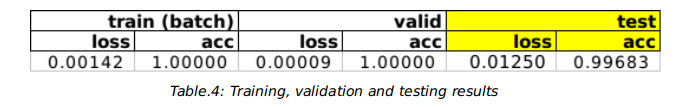

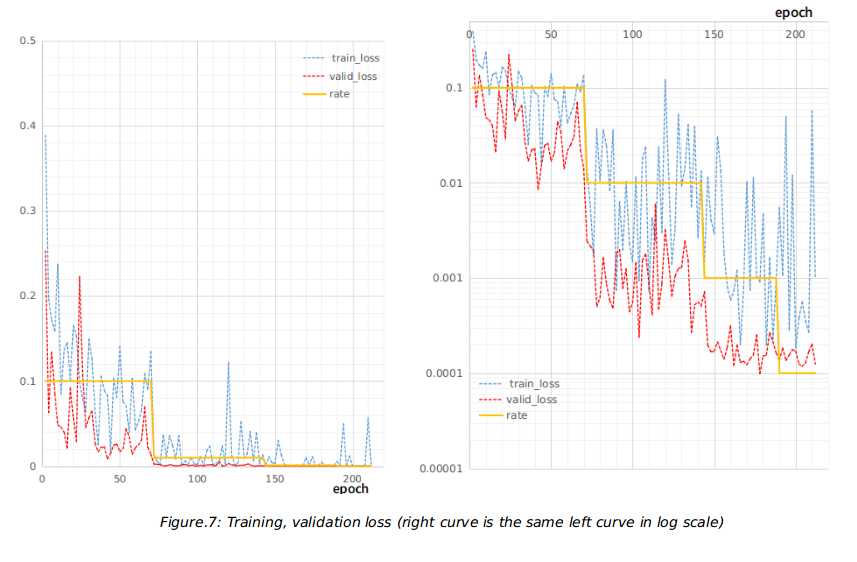

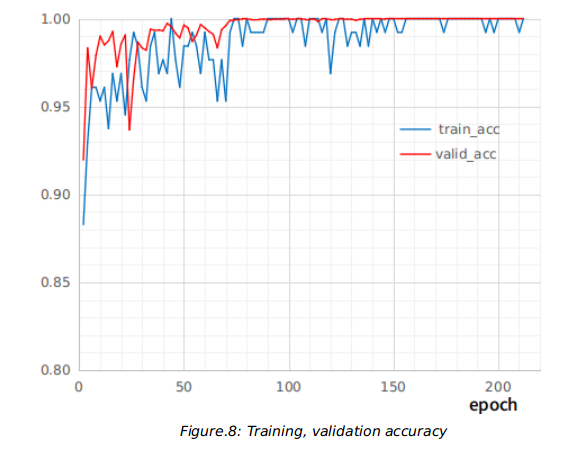

In [4]:
img1=Image(filename="/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/advance/docs/002.png")
img2=Image(filename="/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/advance/docs/003.png")
img3=Image(filename="/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/advance/docs/004.png")
display(img1,img2,img3)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Here are our observations:

(1) Establish a target accuracy we want to achive. From searching the internet[3], we know that:

    - human performance: 98.84%
    - industrial performance: 99.82%
    - works by others: 99.10% to 99.67%

    Hence we think that a reasonable well trained system should be about 99.5% accuracy. 


(2) Train a simple conv net to establish baseline results. Our experiments shows that

    - simple LeNet + no dropout + no augmentation: ~90%
    - simple LeNet + dropout + no augmentation: ~93%
    - simple LeNet + dropout + augmentation: ~95%
    - simple LeNet + dropout + augmentation + preprocessing (whitening): ~97%
    
(Note: simple LeNet = 108_5x5conv_relu-maxpool, 108_5x5conv_relu-maxpool, 100_dense_relu, 100_dense_relu, 43_dense)

From these results, we think that data agumentation and preporcessing could be the key to get higher results. As for newtork structure, LeNet performance seems to be saturated. We have tried Vgg and Denset and decide to use Densenet as our final solution.


(3) Study the data. We confirm that illumination is a key problem.  

---

Based on the observations above, we try the following:

(1)  Select a network and tune it.

We choose "Densenet" becuase we think it connect the lower layers to the top. But we did not do much experiments to see how important this is. We try different number of concatentations, different number of kernels and dropput parameters. We find that the orginal "Densenet" is very sensitive to dropout (maybe because the dropout can propagate and get magnified within the block?). Hence we move the droupout out of the block.

(2)  Once we fix the network, we choose pre-processing. We try whitening, LRN but find that they are quite slow and doesn't really imporve the results once we have large data argumentation. Hence we decide to got for something simpler, i.e. just include the preprocessing inside the network.

(3) Lastly we try different arugmentations. We find that too much argumentation is no good. we have to limit to the correct rotation, scale, translate, perspective distrortion, brighness, contrast, satuation, etc. We note that final results is sensitive to argumentation. 

For each experiment, we carefully record the loss curve. We try different learning rates and weight reqularisation, including L1, L2 and L1+L2. On the whole, it is very much trial and error. Speed of developemnt and training is a key for accuracy improvement. We can't improve results unless we try enough experiments!



[3] Our blogs: 
- https://medium.com/@hengcherkeng/updated-my-99-40-solution-to-udacity-nanodegree-project-p2-traffic-sign-classification-5580ae5bd51f#.28l99uq77


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

num=5


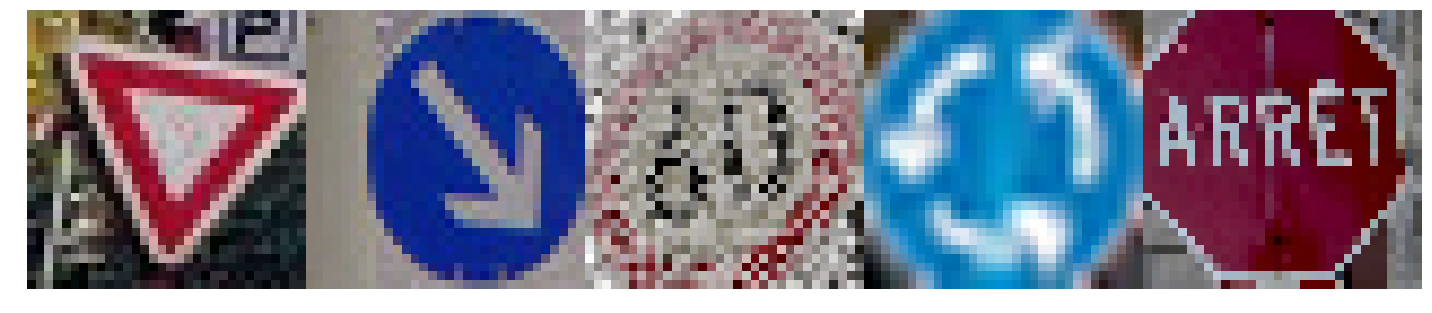

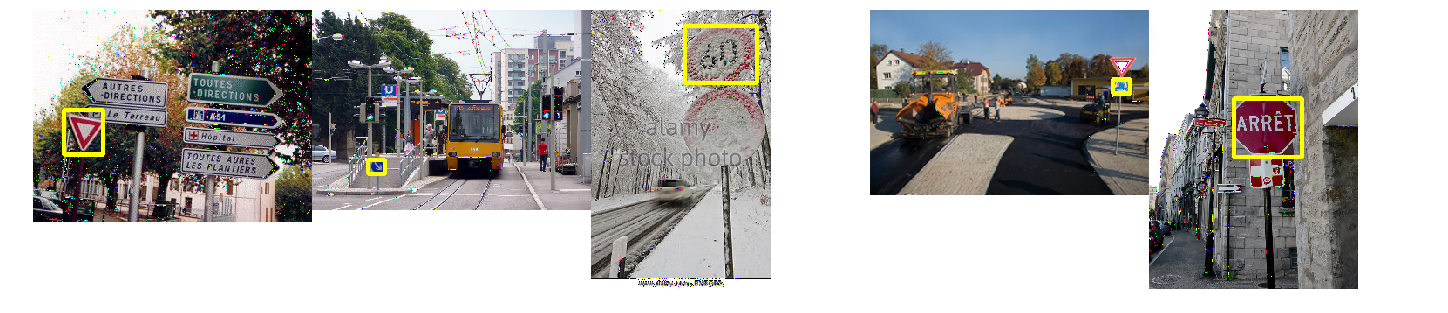

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

test_files=['0004.jpg',   #normal
            '0000.jpg',   #normal
            '0007.jpg',   #occluded with snow
            '0006.jpg',   #small
            '0005.jpg',   #not in class
            ]
test_rois =[(54,180,125,260),(160,430,207,469),(181,32,321,142),(226,65,242,78 ),(388,408,700,676)]
test_label=[13,38,3,40,14]

num=len(test_files)
print('num=%d'%num)

# crop roi to 32x32 
results_image  = 255. * np.ones(shape=(1 * height, num* width, channel),dtype=np.float32) 
results_image1 = 255. * np.ones(shape=(1 * 320, num* 320, channel),dtype=np.float32)  
crops = np.zeros(shape=(num,height,width,channel),dtype=np.float32)
for n in range(num):
    img = cv2.imread(DATA_DIR+'/extra/' + test_files[n], 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) 
    x1, y1, x2, y2 = test_rois[n] 
    crop = cv2.resize(img[y1:y2, x1:x2, :], (0, 0), fx=32. / (x2 - x1), fy=32. / (y2 - y1),
                      interpolation=cv2.INTER_CUBIC)
    
    crop = np.clip(crop,0,255)
    crops[n]=crop
    insert_subimage(results_image, crop, 0, n*width)

    
    #mak roi and show
    H,W,C=img.shape
    S=max(H,W)
    f=320./S
    norm_img = cv2.resize(img, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_CUBIC)  
    cv2.rectangle(norm_img, (round(f*x1), round(f*y1)), (round(f*x2), round(f*y2)), (255,255,0), 3)
    insert_subimage(results_image1, norm_img, 0, n*320)     
    #cv2.imshow('crop', crop)
    #cv2.imshow('img', img)
    #cv2.waitKey(0)

cv2.imwrite(OUT_DIR+'/extra_crops.jpg',  cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB) )
cv2.imwrite(OUT_DIR+'/extra_marked.jpg', cv2.cvtColor(results_image1, cv2.COLOR_BGR2RGB) )
plt.rcParams["figure.figsize"] = (25,25)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

plt.imshow(results_image1.astype(np.uint8))
plt.axis('off') 
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
We downloaded 5 images from the internet and determine the roi region of the traffic sign by hand. The images are:

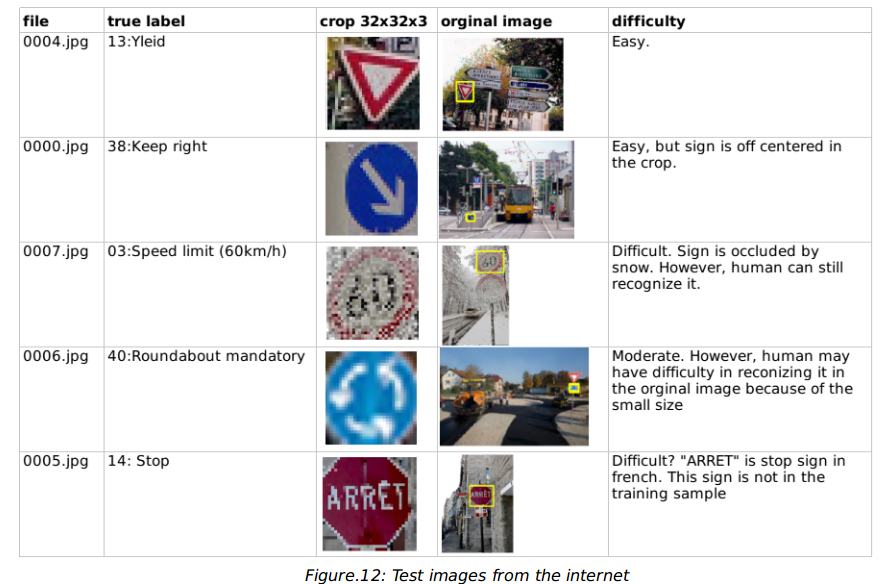

In [7]:
img1=Image(filename="/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/advance/docs/006.png")
display(img1)

In [11]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

#remember to preprocess!
new_images = crops #preprocess(crops)

# load trained classifier
saver  = tf.train.Saver()
saver.restore(sess, OUT_DIR + '/check_points/final.ckpt')

print('** test on extra **')
fd = {data: new_images, IS_TRAIN_PHASE: False}
test_prob = sess.run(prob, feed_dict=fd)

print('see printout of results in the next jupyter cell!')       
print('sucess')

** test on extra **
see printout of results in the next jupyter cell!
sucess


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Accuracy is 80%, 4 out of 5 is correct. The results are:

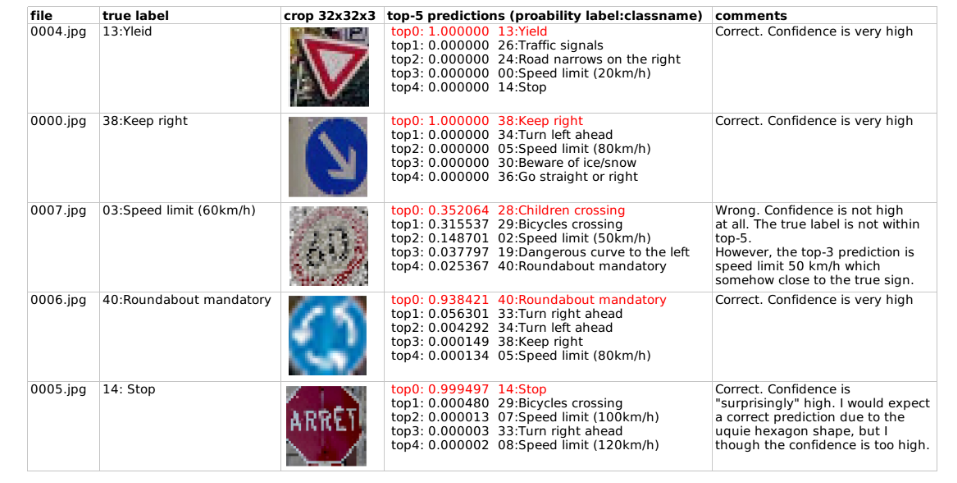

In [9]:
img1=Image(filename="/root/share/docs/git/hengck23-udacity/udacity-driverless-car-nd-p2/advance/docs/007.png")
display(img1)

n=0: true = 13:Yield
	top0: 1.000000  13:Yield
	top1: 0.000000  26:Traffic signals
	top2: 0.000000  24:Road narrows on the right
	top3: 0.000000  00:Speed limit (20km/h)
	top4: 0.000000  14:Stop

n=1: true = 38:Keep right
	top0: 1.000000  38:Keep right
	top1: 0.000000  34:Turn left ahead
	top2: 0.000000  05:Speed limit (80km/h)
	top3: 0.000000  30:Beware of ice/snow
	top4: 0.000000  36:Go straight or right

n=2: true = 03:Speed limit (60km/h)
	top0: 0.352064  28:Children crossing
	top1: 0.315537  29:Bicycles crossing
	top2: 0.148701  02:Speed limit (50km/h)
	top3: 0.037797  19:Dangerous curve to the left
	top4: 0.025367  40:Roundabout mandatory

n=3: true = 40:Roundabout mandatory
	top0: 0.938421  40:Roundabout mandatory
	top1: 0.056301  33:Turn right ahead
	top2: 0.004292  34:Turn left ahead
	top3: 0.000149  38:Keep right
	top4: 0.000134  05:Speed limit (80km/h)

n=4: true = 14:Stop
	top0: 0.999497  14:Stop
	top1: 0.000480  29:Bicycles crossing
	top2: 0.000013  07:Speed limit (100km/h

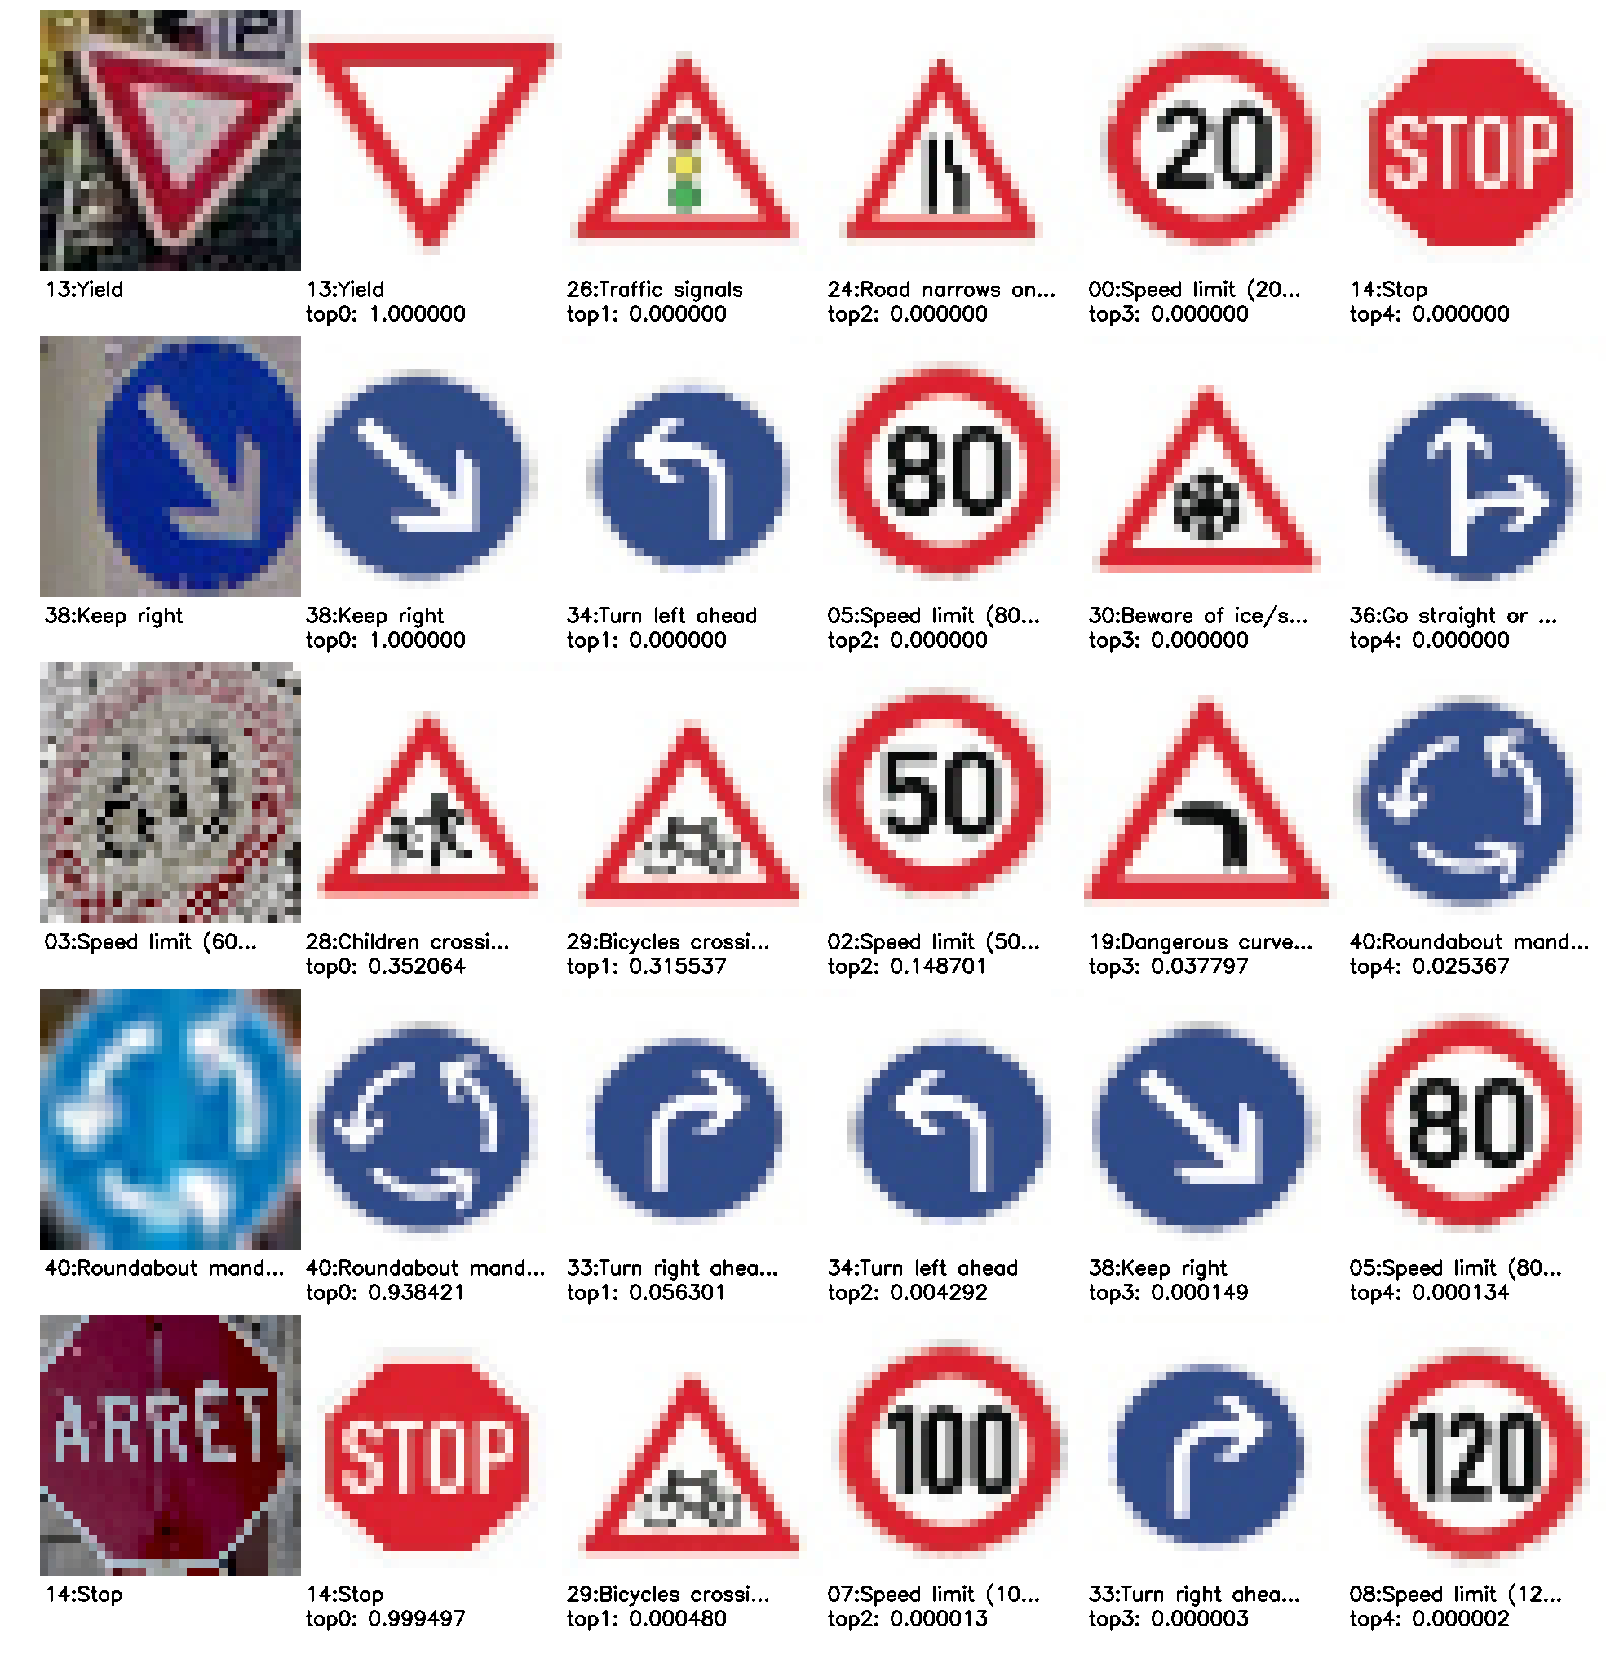

In [12]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

#show results 
f=10
results_image = 255. * np.ones(shape=(5*(f*height + f*8), 6*f*width, channel), dtype=np.float32)

for n in range(num):
    crop = crops[n] 
    c_hat=test_label[n]
    c_hat_label = classnames[c_hat] if c_hat>=0 else 'NIL'
    print('n=%d: true = %02d:%s' % (n, c_hat,c_hat_label))
    
    #crop = cv2.resize(crop, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_NN)
    crop = crop.repeat(f, axis=0).repeat(f, axis=1)
    insert_subimage(results_image, crop, n * (f*height + f*8), 0) 
    cv2.putText(results_image, '%02d:%s%s' % (c_hat,c_hat_label[0:15], '...' if len(classnames[c_hat])>15 else ''), 
                (5, (n+1) * (f*height + f*8)-50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
     

    p = test_prob[n]
    idx = np.argsort(p)[::-1]
    for k in range(5):
        c = int(idx[k])
        label_image = get_label_image(c)
        #label_image = cv2.resize(label_image, (0, 0), fx=f, fy=f, interpolation=cv2.INTER_NN)
        label_image = label_image.repeat(f, axis=0).repeat(f, axis=1)
        insert_subimage(results_image, label_image, n * (f*height + f*8), (k + 1) * f*width)


        print('\ttop%d: %f  %02d:%s' % (k, p[c], c, classnames[c]))
        cv2.putText(results_image, '%02d:%s%s' % (c, classnames[c][0:15], '...' if len(classnames[c])>15 else ''), 
                    (5+(k + 1) * f*width, (n+1) * (f*height + f*8)-50), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
        cv2.putText(results_image, 'top%d: %f' % (k, p[c]), 
                    (5+(k + 1) * f*width, (n+1) * (f*height + f*8)-20), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
    print('')
     

    
print('')
print('')    
print('**visual results**:  input, followed by top-5')
cv2.imwrite(OUT_DIR+'/extra_predictions.jpg', cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB) )
plt.rcParams["figure.figsize"] = (30,30)
plt.imshow(results_image.astype(np.uint8))
plt.axis('off') 
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

Our classifier is correct for "normal" and "small" cases. What it is correct the top-1 score is very high.

Our classifier is wrong for "occluded with snow" case. Here, the top score is only 0.35. The correct label is not within the top 5 at all. This is indeed a difficult case.

For the last case, the test image is not in the training sample. But the classifier makes a reasonable prediction. The "stop sign" is indeed the closest match to the test image (the color and hexagon shape). The top-1 score may seem to be too high however.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.